# I. Transformers Architecture

Transformers are a neural network architecture built around self-attention, which lets a model consider all parts of an input sequence at the same time. This design makes transformers extremely good at understanding context and relationships in language, which is why they form the foundation of modern large language models (LLMs) such as GPT, Llama, and Gemma. LLMs use the transformer architecture at massive scale—billions of parameters—to generate, analyze, and reason over text. Agents build on top of LLMs by adding tools, memory, or decision-making loops that let the model act in an environment, retrieve information, or perform tasks autonomously. In other words: transformers are the core technology, LLMs are powerful models built from transformers, and agents are systems that use LLMs to interact with the world intelligently.

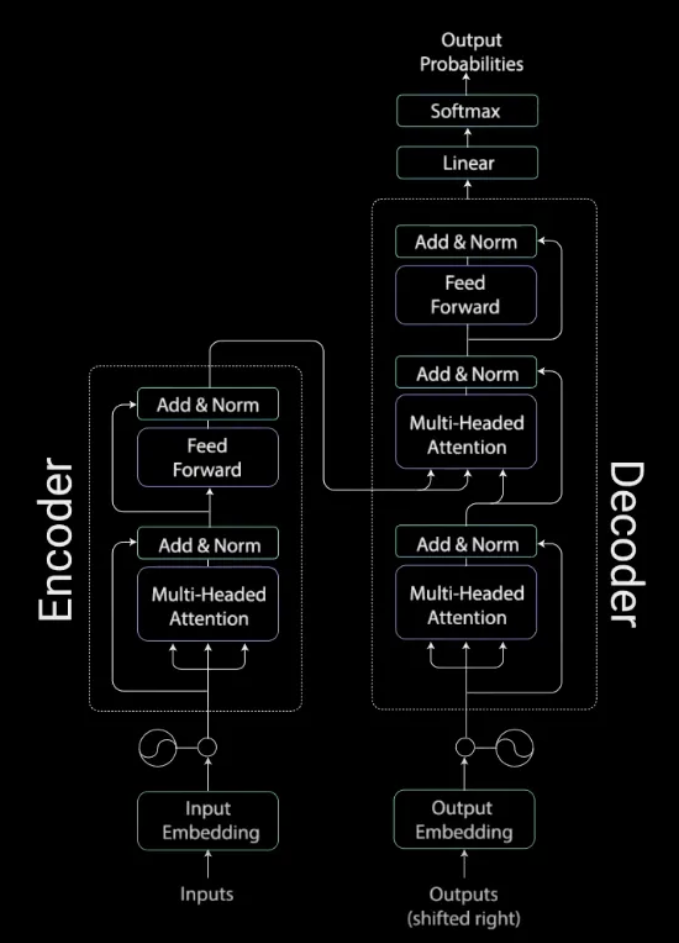

## Input embeddings

First, the input is converted into word embeddings.

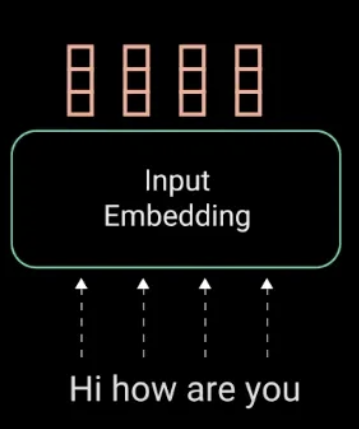

## Positional Encoding
We add positional information to the word embeddings.

A vector is created for each word with its positional information using the functions **$sin$** and **$cos$**.

Each word embedding is added to its positional vector.

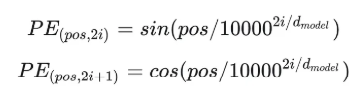

## Encoder

It transforms input data into another representation of the same data, incorporating the information learned by the encoder.
It's composed of two layers:

- Multi-Headed Attention Layer

- Feed Forward Layer

Both layers have residual connections followed by a normalization layer.

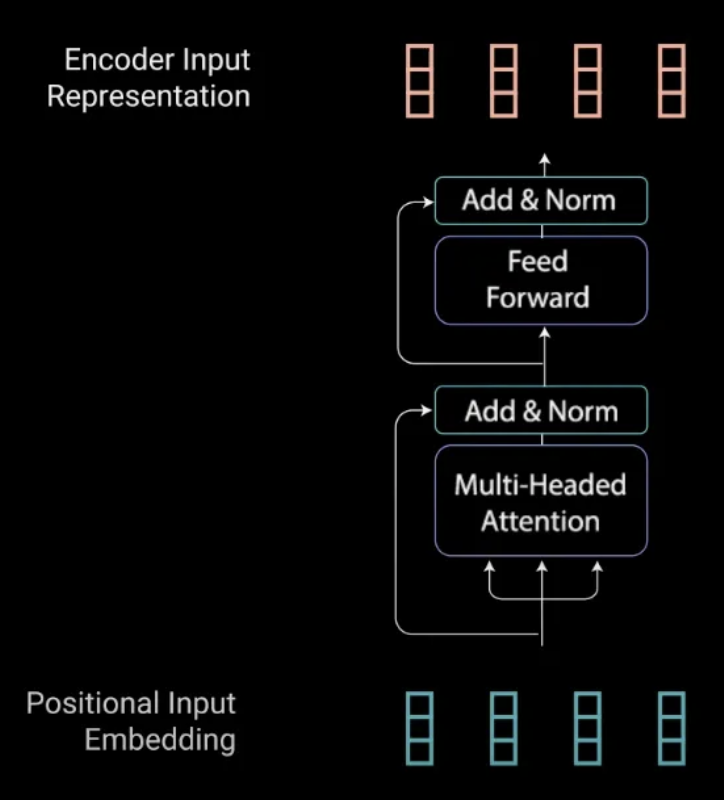

### Multi-Headed Attention Layer

* Applies the attention mechanism, called **self-attention**, relating each word to the other words.

In the example, it searches for the relationship of each word in "Hi how are you" to the rest.

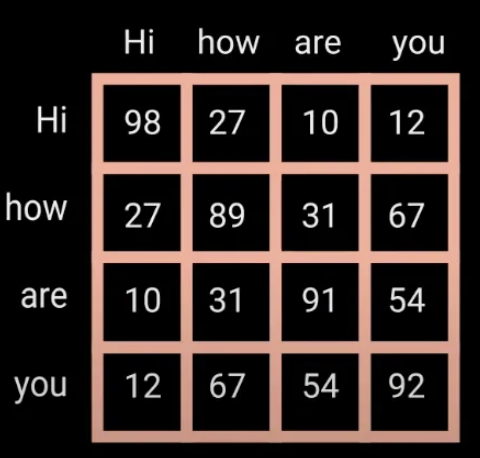

## Decoder

The decoder is autoregressive: it starts with a start token, and takes as inputs a list of previous outputs, as well as the encoder outputs. It stops decoding when it generates a token as output.

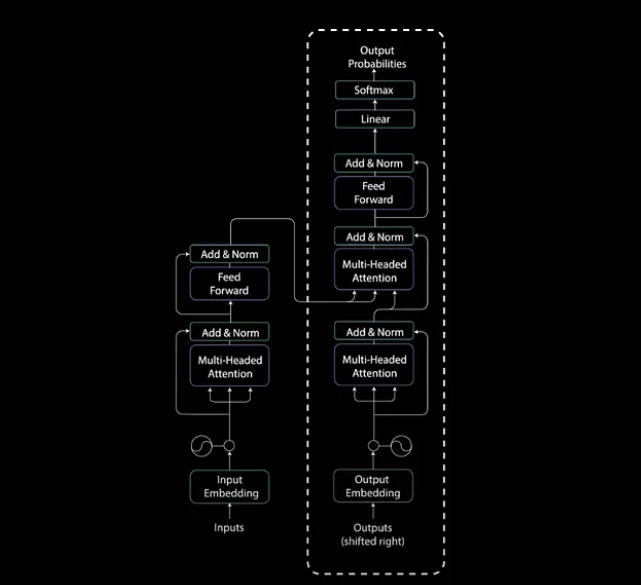

### First Multi-Head Attention Layer of the Decoder

This is a masked multi-head attention layer: A look-ahead mask is applied to the multi-head attention to prevent the decoder from attending to future tokens.

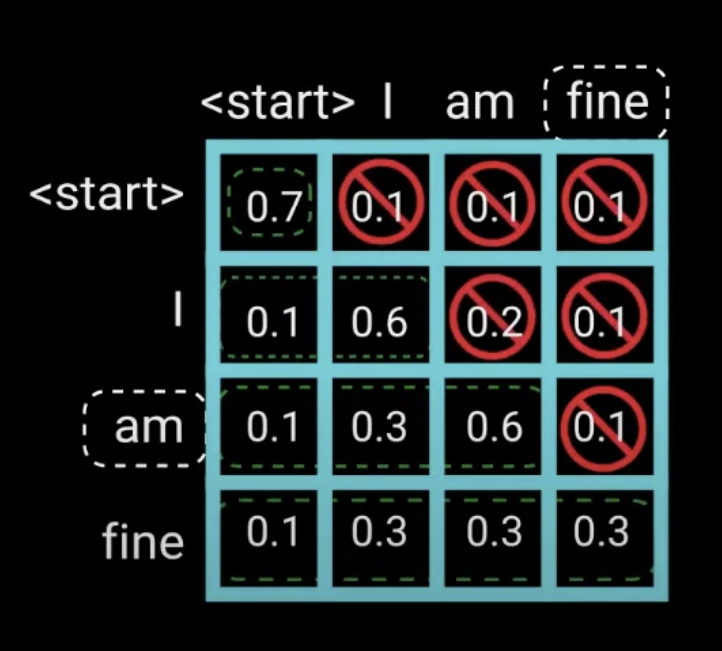

### Second Multi-Headed Attention Layer and Point-Wise Feed Forward Layer of the Decoder
In the Multi-Headed Attention Layer:

- The query vectors are the output of the first Multi-Headed Attention Layer.
- The key and value vectors are the output of the encoder.

The output of the second Multi-Headed Attention Layer passes through a feed-forward network.

### Linear Layer and Final Softmax Layer
The output of the last Feedforward Network passes through a final layer with linear activation:

- It acts as a classifier.
- It will have as many neurons as there are classes to predict.

The classifier's output is fed into a softmax layer. It will produce probability scores between 0 and 1, and we take the score of the highest probability. -> and that equates to our predicted word.

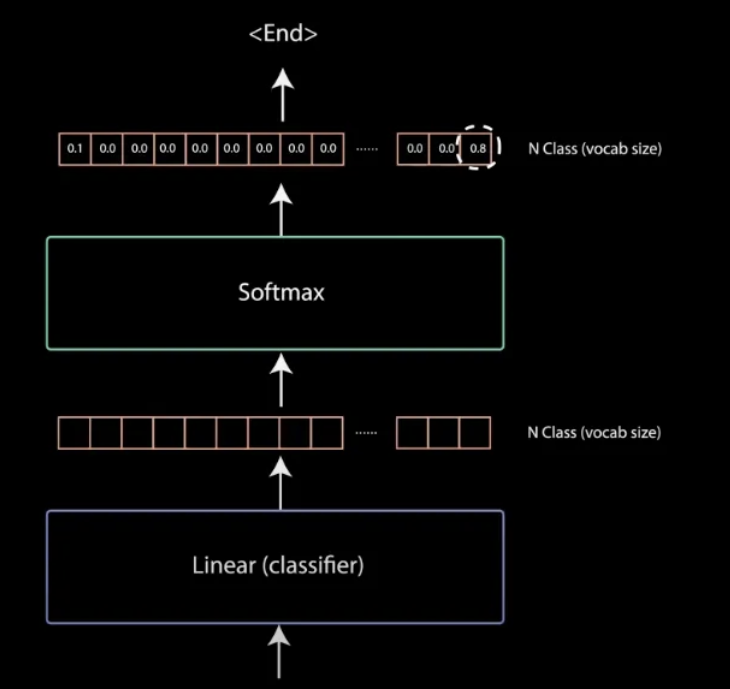

Next, the Decoder takes the output, adds it to the Decoder's input list, and continues decoding again until the final token \<End> is predicted.

## Types of Transformers:

* **Encoder-Decoder**: Optimized for tasks such as text translation or text summarization. Example: the original Transformer or Meta's Peer model.
* **Encoder-Only**: Specifically designed to solve problems such as sentiment analysis or text classification. Example: Bert.
* **Decoder-Only**: Optimized for text generation. Example: GPT3, LaMDA, and PaLM.


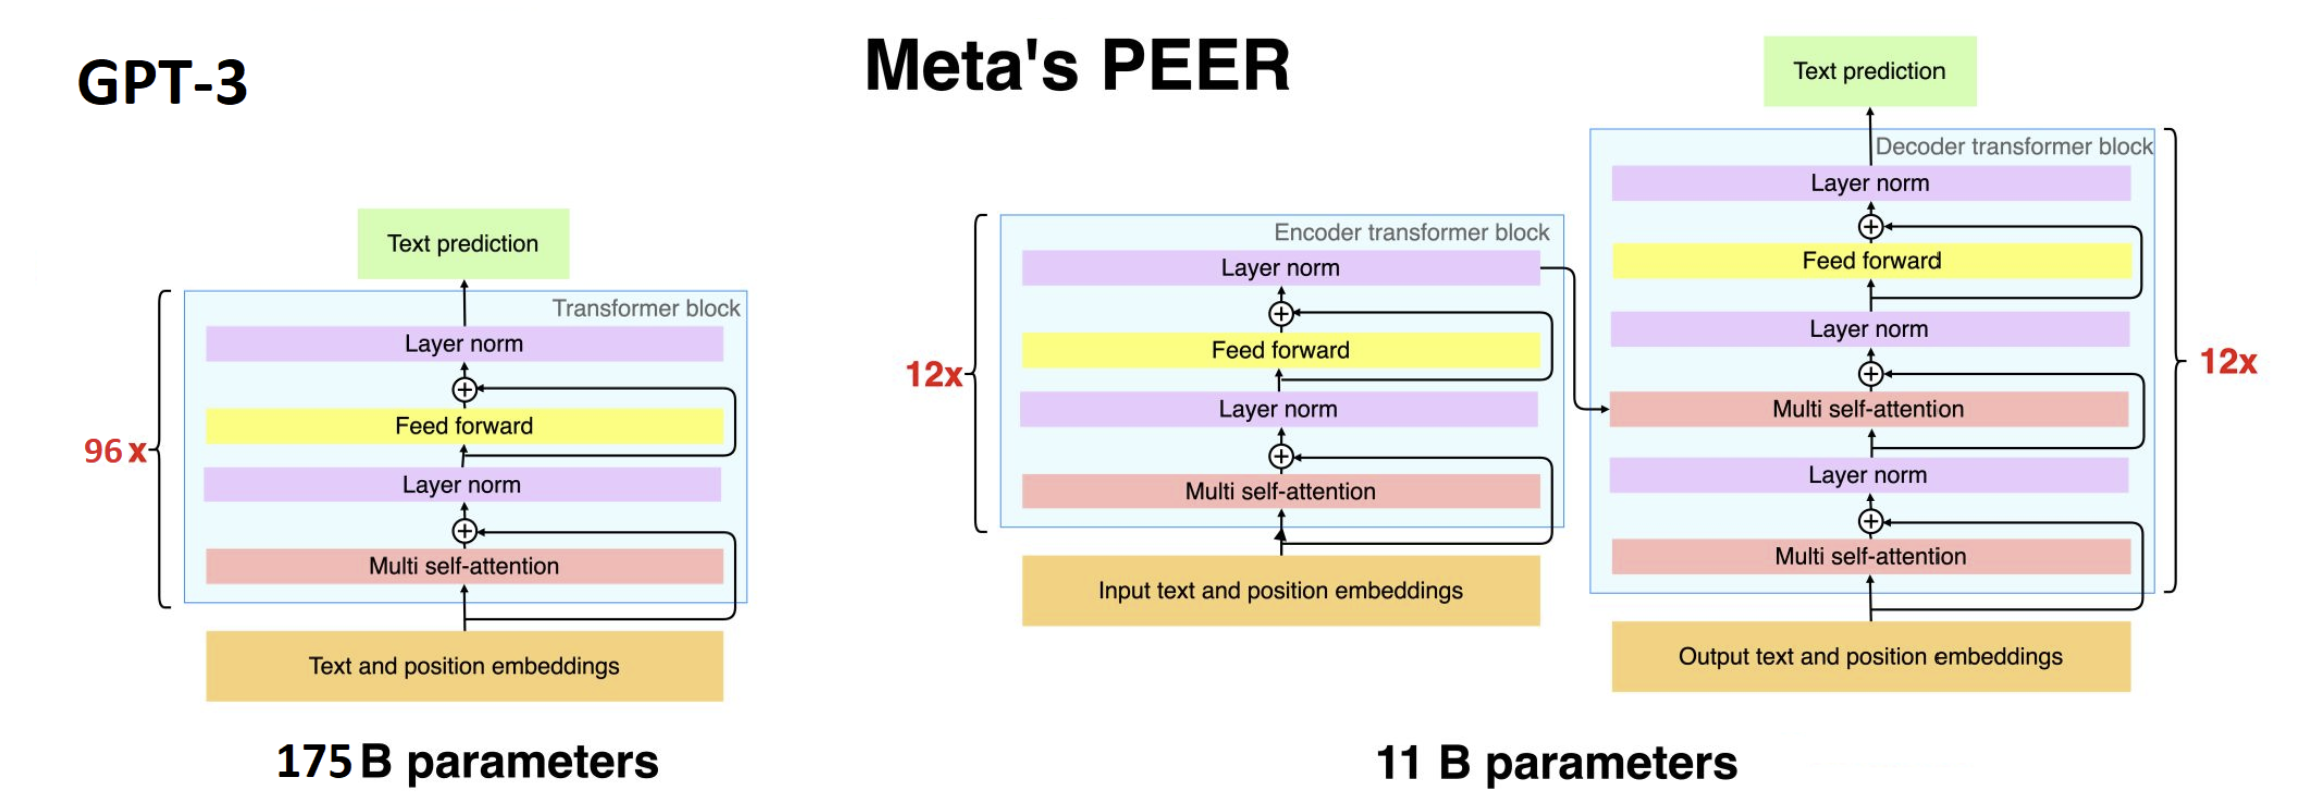

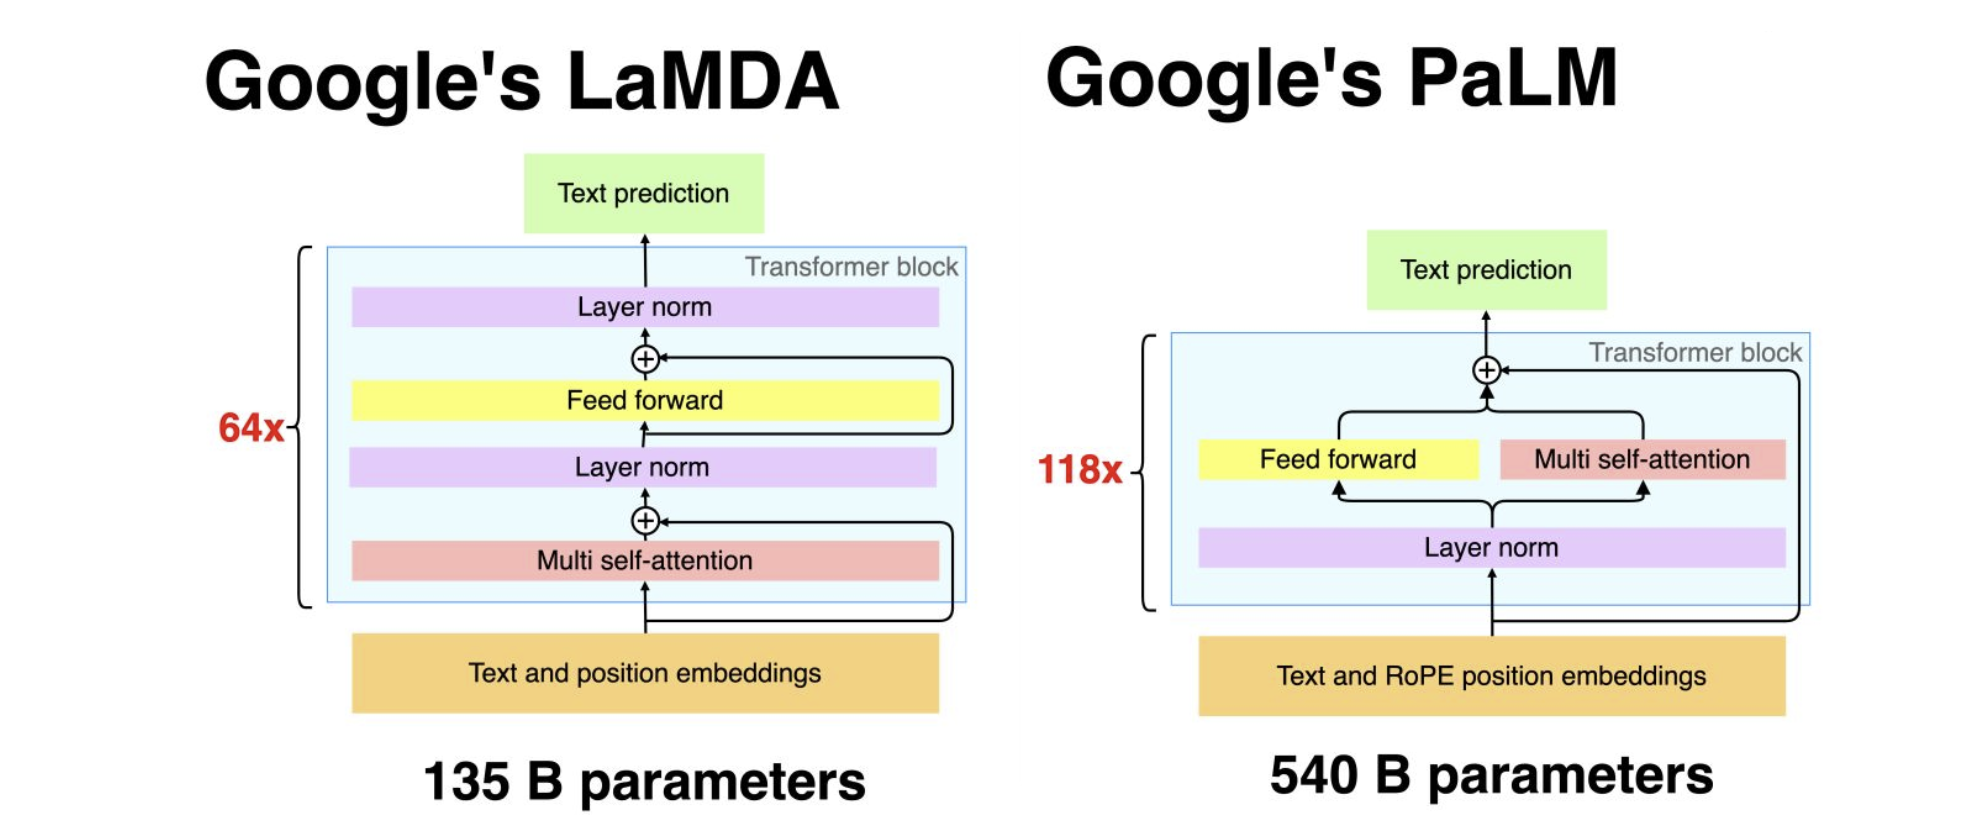

# II. Decoding Strategies for Text Generation with GPT-2

in this section we will explore different decoding strategies for generating text with the GPT-2 model. We will cover the following methods:

- **Greedy Decoding**
- **Beam Search**
- **Sampling (with top-k and top-p)**

For each strategy, we will provide a brief explanation, a code implementation using the Hugging Face `transformers` library, and an analysis of the generated output. Finally, we will compare the strategies and discuss their trade-offs.

## Setup

Now we will load the GPT-2 model and its tokenizer using the Hugging Face Transformers library.

In [1]:
!pip install -q transformers
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# 1. First we download the tokenizer, which is responsible for converting text
# into numerical tokens the model can understand

tokenizer = AutoTokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [3]:
# 2. Then we load the GPT-2 causal language model itself, setting its
# pad_token_id to the tokenizer’s end-of-sentence token
# (because GPT-2 doesn’t have a built-in padding token)

model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id).to(torch_device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [4]:
# 3. Finally we prepare our sentence for the model to process.
# tokenizer(...) converts the sentence into token IDs
# return_tensors='pt' tells the tokenizer to return the data as PyTorch tensors

model_inputs = tokenizer('I enjoy walking with my cute dog', return_tensors='pt').to(torch_device)

In [5]:
# Try tokenizing a different sentence. What happens?
# my_sentence = "YOUR SENTENCE HERE"
# INSERT YOUR CODE HERE

## Greedy Decoding

Greedy search is the simplest decoding method. It selects the word with the highest probability as its next word at each timestep. While fast and simple, it can lead to repetitive and non-creative text because it doesn't consider the overall sequence probability.

In [6]:
# Generate text using greedy search
set_seed(42)
greedy_output = model.generate(**model_inputs, max_new_tokens=40) ##

print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with my dog. I'm not sure if I'll ever be able to walk with my dog.

I'm not sure


In [7]:
# Generate text using greedy search with your own prompt
# Try modifying the prompt below and setting max_new_tokens to different values

# your_prompt = "INSERT YOUR PROMPT HERE"
# INSERT YOUR CODE HERE

## Beam Search

Beam search reduces the risk of missing a high-probability sequence by keeping track of `num_beams` hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. This can lead to more fluent and coherent text than greedy search.

In [8]:
# Generate text using beam search
set_seed(42)
beam_output = model.generate(
    **model_inputs,
    max_new_tokens=40,
    num_beams=5,
    early_stopping=True
)

print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I'm not sure if I'll ever be able to walk with him again. I'm not sure


We can also use `no_repeat_ngram_size` to prevent the model from repeating the same n-grams.

In [9]:
# Generate text using beam search with n-gram penalty
set_seed(42)
beam_output_no_repeat = model.generate(
    **model_inputs,
    max_new_tokens=40,
    num_beams=5,
    no_repeat_ngram_size=2,
    early_stopping=True
)

print(tokenizer.decode(beam_output_no_repeat[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to


In [10]:
# Try experimenting with different beam search parameters
# Modify num_beams and no_repeat_ngram_size to see how they affect the output

beam_output_custom = model.generate(
    **model_inputs,
    max_new_tokens=40,
    num_beams=3,  # Try changing this
    no_repeat_ngram_size=2,  # And this
    early_stopping=True
)
print(tokenizer.decode(beam_output_custom[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog, but I don't think I'll ever be able to walk with her again."

"I'm sure you'll be fine," she said. "But I'm not sure I want to


## Sampling

Sampling methods introduce randomness into the decoding process, which can lead to more creative and diverse outputs. We will explore two popular sampling techniques: **top-k** and **top-p (nucleus)** sampling.

### Top-k Sampling

Top-k sampling filters the vocabulary to the `k` most likely next words and redistributes the probability mass among them. This helps to avoid sampling from very low-probability words, making the output more coherent.

In [11]:
# Generate text using top-k sampling
set_seed(42)
top_k_output = model.generate(
    **model_inputs,
    max_new_tokens=40,
    do_sample=True,
    top_k=50
)

print(tokenizer.decode(top_k_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog, which is a little unusual in this part of our family. He's a friendly, calm kind of dog, and I've always wanted to have him around, and I always wanted to go with


### Top-p (Nucleus) Sampling

Top-p sampling, also known as nucleus sampling, chooses from the smallest possible set of words whose cumulative probability exceeds a certain threshold `p`. This allows the number of words in the sampling pool to dynamically adapt based on the context.

In [12]:
# Generate text using top-p sampling
set_seed(42)
top_p_output = model.generate(
    **model_inputs,
    max_new_tokens=40,
    do_sample=True,
    top_p=0.92,
    top_k=0
)

print(tokenizer.decode(top_p_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog, Daddy," a barter in the popular underground Twitter service Twitchell agreed.

Like it or not, "It's been a while," American Indian Salwa Donna Dal made me laugh


### Sampling with Temperature

The `temperature` parameter controls the randomness of the sampling process. A lower temperature makes the model more confident in its top choices, while a higher temperature increases diversity.

In [13]:
# Generate text using sampling with temperature
set_seed(42)
temperature_output = model.generate(
    **model_inputs,
    max_new_tokens=40,
    do_sample=True,
    top_k=0,
    temperature=0.6
)

print(tokenizer.decode(temperature_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog, and I was delighted to have him on my show, so I had a chance to see him. I was very impressed with his body, and I am looking forward to seeing what he has to


In [15]:
# Try different temperature values to control randomness
# Lower temperature (e.g., 0.3) = more focused, Higher temperature (e.g., 1.5) = more diverse

custom_temperature = 0.8  # Try changing this value
custom_temp_output = model.generate(
    **model_inputs,
    max_new_tokens=40,
    do_sample=True,
    top_k=0,
    temperature=custom_temperature
)

print(f"Temperature {custom_temperature}:")
print(tokenizer.decode(custom_temp_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Temperature 0.8:
I enjoy walking with my cute dog. We are part of the group that his father raised, and we are proud of him. We think our unit does a wonderful job.

But I was not going to let him in.


In [17]:
!wget -O text_evaluator.py https://raw.githubusercontent.com/Bor90/Nuclio_GenAI/refs/heads/main/Notebooks/Solutions/Day1/evaluator/text_evaluator.py

--2026-01-22 11:20:51--  https://raw.githubusercontent.com/Bor90/Nuclio_GenAI/refs/heads/main/Notebooks/Solutions/Day1/evaluator/text_evaluator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10912 (11K) [text/plain]
Saving to: ‘text_evaluator.py’

text_evaluator.py   100%[===================>]  10.66K  --.-KB/s    in 0s      

2026-01-22 11:20:51 (66.7 MB/s) - ‘text_evaluator.py’ saved [10912/10912]



In [18]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [19]:
# Evaluate your custom sampling outputs
from text_evaluator import evaluate_text, print_results

my_text = tokenizer.decode(custom_temp_output[0], skip_special_tokens=True)
metrics = evaluate_text(my_text)
print_results(metrics, "My Experiment")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Evaluation Results for: My Experiment

📏 LENGTH METRICS:
  word_count: 45
  sentence_count: 4
  avg_words_per_sentence: 11.25
  char_count: 183

✨ QUALITY METRICS:
  Diversity Score: 0.8000 (higher is better)
  Repetition Score: 0.0230 (lower is better)
  Coherence Score: 0.7245 (higher is better)
  Fluency Score: 0.8000 (higher is better)

🎯 OVERALL SCORE: 0.8254/1.0


## Comparison and Trade-offs

Now, let's compare the outputs from each decoding strategy and discuss their trade-offs.

In [20]:
print("Greedy Output:")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))
print('---')
print("Beam Search Output:")
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))
print('---')
print("Beam Search (no-repeat) Output:")
print(tokenizer.decode(beam_output_no_repeat[0], skip_special_tokens=True))
print('---')
print("Top-k Output:")
print(tokenizer.decode(top_k_output[0], skip_special_tokens=True))
print('---')
print("Top-p Output:")
print(tokenizer.decode(top_p_output[0], skip_special_tokens=True))
print('---')
print("Temperature Output:")
print(tokenizer.decode(temperature_output[0], skip_special_tokens=True))

Greedy Output:
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with my dog. I'm not sure if I'll ever be able to walk with my dog.

I'm not sure
---
Beam Search Output:
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I'm not sure if I'll ever be able to walk with him again. I'm not sure
---
Beam Search (no-repeat) Output:
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to
---
Top-k Output:
I enjoy walking with my cute dog, which is a little unusual in this part of our family. He's a friendly, calm kind of dog, and I've always wanted to have him around, and I always wanted to go with
---
Top-p Output:
I enjoy walking with my cute dog, Daddy," a barter in the popular underground Twitter service Twitchell agreed.

Like it or not, "It's been a while," American Indian Salwa Donna Dal made

| Strategy | Pros | Cons | Best for |
|---|---|---|---|
| **Greedy** | Fast, simple, deterministic | Repetitive, not creative, can miss better sequences | Short, factual text |
| **Beam Search** | More fluent and coherent than greedy | Slower, still can be repetitive, not guaranteed to find optimal sequence | Tasks with predictable output length (e.g., translation) |
| **Sampling (Top-k/Top-p)** | Creative, diverse, more human-like | Can be incoherent or random, less deterministic | Open-ended generation, creative writing, dialogue |

In [ ]:
# Try combining different sampling parameters
set_seed(42)

custom_parameters_1 = model.generate(
    **model_inputs,
    max_new_tokens= # YOUR VALUE HERE ,
    do_sample=True,
    top_k= # YOUR VALUE HERE ,
    temperature= # YOUR VALUE HERE ,
    top_p= # YOUR VALUE HERE ,
)

custom_parameters_2 = model.generate(
    **model_inputs,
    # YOUR CODE HERE
)

# PRINT YOUR OUTPUTS HERE

In [ ]:
# Load the text evaluator library
import sys
sys.path.append('.')
from text_evaluator import TextEvaluator, compare_texts, print_comparison

# Initialize evaluator
evaluator = TextEvaluator()

# Collect all generation results
all_results = {
    'Greedy': tokenizer.decode(greedy_output[0], skip_special_tokens=True),
    'Beam Search': tokenizer.decode(beam_output[0], skip_special_tokens=True),
    'Beam Search (no-repeat)': tokenizer.decode(beam_output_no_repeat[0], skip_special_tokens=True),
    'Top-k': tokenizer.decode(top_k_output[0], skip_special_tokens=True),
    'Top-p': tokenizer.decode(top_p_output[0], skip_special_tokens=True),
    'Temperature': tokenizer.decode(temperature_output[0], skip_special_tokens=True),
    'Custom Experiment': tokenizer.decode(custom_temp_output[0], skip_special_tokens=True),
    'Custom Parameters 1': tokenizer.decode(custom_parameters_1[0], skip_special_tokens=True),
    'Custom Parameters 2': tokenizer.decode(custom_parameters_2[0], skip_special_tokens=True),
}

# Evaluate and compare
comparison_results = compare_texts(all_results)
print_comparison(comparison_results)


STRATEGY COMPARISON SUMMARY

📊 Individual Scores by Strategy:
------------------------------------------------------------

GREEDY:
  Overall Score: 0.6086
  Diversity: 0.4444
  Repetition: 0.5517
  Coherence: 0.5417
  Fluency: 1.0000

BEAM SEARCH:
  Overall Score: 0.5697
  Diversity: 0.4889
  Repetition: 0.5517
  Coherence: 0.5417
  Fluency: 0.8000

BEAM SEARCH (NO-REPEAT):
  Overall Score: 0.8789
  Diversity: 0.8222
  Repetition: 0.0000
  Coherence: 0.8936
  Fluency: 0.8000

TOP-K:
  Overall Score: 0.8704
  Diversity: 0.7234
  Repetition: 0.0989
  Coherence: 0.8571
  Fluency: 1.0000

TOP-P:
  Overall Score: 0.9566
  Diversity: 0.8605
  Repetition: 0.0120
  Coherence: 0.9778
  Fluency: 1.0000

TEMPERATURE:
  Overall Score: 0.7659
  Diversity: 0.7021
  Repetition: 0.0549
  Coherence: 0.8163
  Fluency: 0.6000

🏆 Winners by Category:
------------------------------------------------------------
  Best Diversity: Top-p
  Lowest Repetition: Beam Search (no-repeat)
  Best Coherence: Top-p
 

### Automatic Evaluation of Generation Strategies

The `text_evaluator` library provides automated metrics to assess text quality:

- **Diversity Score** (0-1): How varied is the vocabulary? Higher is better.
- **Repetition Score** (0-1): How much are n-grams repeated? Lower is better.
- **Coherence Score** (0-1): How consistent is sentence structure? Higher is better.
- **Fluency Score** (0-1): Does it follow natural language patterns? Higher is better.

This helps you understand the trade-offs between different decoding strategies!

## Evaluating Your Results

Use the evaluator below to analyze the quality of different generation strategies applied to your own prompts.

In [ ]:
# INSERT YOUR CODE HERE
# Evaluate and compare different strategies on YOUR custom prompts
# Uncomment and run to evaluate your own generations:

# from text_evaluator import compare_texts, print_comparison

# my_results = {
#     'strategy_1_name': 'YOUR GENERATED TEXT 1',
#     'strategy_2_name': 'YOUR GENERATED TEXT 2',
#     'strategy_3_name': 'YOUR GENERATED TEXT 3',
# }

# my_comparison = compare_texts(my_results)
# print_comparison(my_comparison)

## Discussion

### Key Observations

**Greedy Decoding** is the fastest and simplest approach, but it tends to produce repetitive text. This is because it always selects the most probable next token without considering the overall sequence probability. For tasks requiring deterministic outputs or when speed is critical, greedy decoding can be useful, but it often lacks creativity and diversity.

**Beam Search** improves upon greedy decoding by maintaining multiple hypotheses and selecting the sequence with the highest overall probability. This reduces the risk of missing high-probability sequences that start with lower-probability tokens. However, beam search can still produce repetitive outputs and is computationally more expensive than greedy decoding. The `no_repeat_ngram_size` parameter helps mitigate repetition by preventing the same n-grams from appearing multiple times.

**Sampling methods** (top-k, top-p, and temperature) introduce randomness into the generation process, leading to more diverse and creative outputs. Top-k sampling restricts the sampling pool to the k most likely tokens, while top-p (nucleus) sampling dynamically adjusts the pool size based on cumulative probability. Temperature controls the sharpness of the probability distribution, with lower values making the model more confident and higher values increasing diversity. These methods are particularly effective for open-ended generation tasks like creative writing and dialogue.

### When to Use Each Strategy

- **Greedy Decoding**: Use when you need fast, deterministic outputs for short text generation tasks where creativity is not a priority.

- **Beam Search**: Use for tasks with predictable output lengths, such as machine translation, summarization, or image captioning, where you want to balance quality and computational cost.

- **Top-k Sampling**: Use for open-ended generation where you want to avoid very low-probability tokens while maintaining some diversity.

- **Top-p Sampling**: Use for creative writing, dialogue generation, or any task where you want the model to adapt its creativity based on context.

- **Temperature Sampling**: Use when you want fine-grained control over the randomness of the output. Lower temperatures (0.5-0.7) produce more focused text, while higher temperatures (0.8-1.2) produce more diverse text.

### Further Exploration

Try experimenting with different parameter values:

- Change `num_beams` in beam search to see how it affects output quality
- Adjust `top_k` values (e.g., 10, 30, 100) to observe the trade-off between diversity and coherence
- Modify `top_p` values (e.g., 0.8, 0.9, 0.95) to see how the dynamic sampling pool changes
- Experiment with `temperature` values (e.g., 0.3, 0.7, 1.0, 1.5) to control randomness
- Combine `top_k` and `top_p` together for hybrid sampling strategies
- Try different prompts to see how the decoding strategies perform on various types of text

## III. Visualizing Attention: Understanding Model Focus

### Theory
**What is the Attention Mechanism?**
In the architecture of Transformer models (which underpin most modern LLMs like BERT, GPT, T5), the **attention mechanism** is a critical component. It allows the model to weigh the importance of different words (or tokens) in the input sequence when processing each word. Instead of treating all words equally, attention dynamically highlights which parts of the input are most relevant for understanding a particular token or generating an output.

Imagine you are reading a complex sentence. When you focus on a specific word, your brain implicitly pays more attention to other words that provide context for it. The attention mechanism in LLMs works similarly: when the model processes a token, it looks at all other tokens in the sequence and assigns an "attention score" to each, indicating its relevance.

**Why Visualize Attention? Gaining Interpretability**
Transformer models are often considered "black boxes" due to their complex internal workings. Visualizing the attention mechanism helps us to:
*   **Understand Model Focus:** See which input tokens the model is "paying attention to" when processing other tokens.
*   **Gain Interpretability:** Provide insights into how the model makes decisions and generates responses.
*   **Debug and Diagnose:** Identify if the model is focusing on irrelevant information or exhibiting unexpected patterns.
*   **Pedagogical Tool:** It's an excellent way to teach and learn about the internal mechanics of these powerful models.

### Introduction to BertViz
**BertViz** is an interactive visualization tool specifically designed to illustrate the attention mechanism in Transformer-based language models such as BERT, GPT-2, or T5. It can be run directly within Jupyter or Google Colab notebooks, making it highly accessible for educational and research purposes.

BertViz offers several views to help understand attention patterns:

1.  **Head View:**
    *   Visualizes attention for one or more attention heads within a single Transformer layer. Each line typically shows the attention from a query token (on the left) to a key token (on the right).
    *   This view helps to understand how individual attention heads focus on different parts of the input sequence.

2.  **Model View:**
    *   Provides a high-level overview of attention across all layers and heads in the model. It can show aggregated attention patterns or allow drilling down into specific layers/heads.
    *   Useful for understanding the overall flow of information and how attention patterns evolve through the model's layers.

### Exercise: Visualizing Attention with BertViz
We will use `bertviz` to visualize the attention patterns of a pre-trained BERT model. This will help us understand which words the model focuses on when processing a sentence.

In [ ]:
!pip install bertviz transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.8 MB/s eta 0:00:00


BERT-base has 12 layers, and each layer transforms the token representations one step further. As we move deeper through the layers, the model builds more complex and abstract understanding of the input.

In [ ]:
from transformers import AutoTokenizer, AutoModel, pipeline, AutoModelForCausalLM
from bertviz import head_view, model_view
import torch

# Suppress warnings from transformers library for cleaner output
from transformers import logging
logging.set_verbosity_error()

# Load a pre-trained BERT model and tokenizer
# We need to ensure output_attentions=True to get the attention weights
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)

# Define a sentence for analysis
sentence_a = "The quick brown fox jumps over the lazy dog."
sentence_b = "The animal is fast."

# Tokenize the input sentences
# For BERT, we often concatenate sentences with special tokens like [SEP]
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids'] # Identifies which token belongs to which sentence

# Get tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Pass the input through the model to get attention weights
# We use no_grad() because we are only doing inference, not training
with torch.no_grad():
    outputs = model(input_ids, token_type_ids=token_type_ids)
    attention = outputs.attentions # This contains the attention weights

print("--- BertViz Head View (Interactive) ---")
print("Run the cell below to see the interactive visualization.")

# Display the interactive head view
# You can select different layers and heads to explore attention patterns
head_view(attention, tokens, sentence_b_start=len(tokenizer.encode(sentence_a, add_special_tokens=True)) - 1)

# Exercise Challenge:
# 1. In the interactive visualization, select different layers and heads. Can you observe how attention patterns change?
# 2. For the word "fox", which other words does the model pay most attention to? Does this make sense semantically?
# 3. How does the attention change when you look at the relationship between words in `sentence_a` and words in `sentence_b`?
# 4. Try changing the input sentences to something else. What new insights do you gain about BERT's attention?

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

--- BertViz Head View (Interactive) ---
Run the cell below to see the interactive visualization.


<IPython.core.display.Javascript object>

In [ ]:
# INSERT YOUR CODE HERE
# Analyze attention for your own sentence pairs
# Modify sentence_a and sentence_b below to experiment with different inputs
# custom_sentence_a = "YOUR FIRST SENTENCE"
# custom_sentence_b = "YOUR SECOND SENTENCE"
# custom_inputs = tokenizer.encode_plus(custom_sentence_a, custom_sentence_b, return_tensors='pt', add_special_tokens=True)
# custom_input_ids = custom_inputs['input_ids']
# custom_token_type_ids = custom_inputs['token_type_ids']
# custom_tokens = tokenizer.convert_ids_to_tokens(custom_input_ids[0])
# with torch.no_grad():
#     custom_outputs = model(custom_input_ids, token_type_ids=custom_token_type_ids)
#     custom_attention = custom_outputs.attentions
# head_view(custom_attention, custom_tokens, sentence_b_start=len(tokenizer.encode(custom_sentence_a, add_special_tokens=True)) - 1)

- layer = a full Transformer block (big unit).
- head = one attention mechanism inside a layer (small unit).

Layers stack vertically; heads operate in parallel within each layer.

In [ ]:
model_view(attention, tokens, sentence_b_start=len(tokenizer.encode(sentence_a, add_special_tokens=True)) - 1)

In [ ]:
sentence = "The bank approved the loan"
inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
outputs = model(**inputs)
attention = outputs.attentions
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
head_view(attention, tokens)

In [ ]:
sentence = "The bank of the river was flooded"
inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
outputs = model(**inputs)
attention = outputs.attentions
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
head_view(attention, tokens)

In [ ]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True, pad_token_id=tokenizer.eos_token_id)

# Prompt
sentence = "The Doctor asked the Nurse a question. She"

# Encode
inputs = tokenizer(sentence, return_tensors="pt")

# Generate while keeping attentions
outputs = model.generate(
    **inputs,
    max_new_tokens=15,
    do_sample=False,
    output_attentions=True,
    return_dict_in_generate=True
)

generated_ids = outputs.sequences
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Generated text:", generated_text)

In [ ]:
# INSERT YOUR CODE HERE
# Try your own prompt with GPT-2 and visualize its attention patterns
# Notice how the model handles pronouns and references
# custom_gpt_sentence = "INSERT YOUR PROMPT ENDING WITH A PRONOUN OR SUBJECT"
# custom_gpt_inputs = tokenizer(custom_gpt_sentence, return_tensors="pt")
# custom_gpt_outputs = model.generate(
#     **custom_gpt_inputs,
#     max_new_tokens=15,
#     do_sample=False,
#     output_attentions=True,
#     return_dict_in_generate=True
# )
# custom_generated_ids = custom_gpt_outputs.sequences
# custom_generated_text = tokenizer.decode(custom_generated_ids[0], skip_special_tokens=True)
# print("Generated text:", custom_generated_text)

In [ ]:
with torch.no_grad():
    outputs = model(generated_ids, output_attentions=True)

tokens = tokenizer.convert_ids_to_tokens(generated_ids[0])
attentions = outputs.attentions

head_view(attentions, tokens)

In [ ]:
sentence = "The Doctor asked the Nurse a question. He"
inputs = tokenizer(sentence, return_tensors="pt")
outputs = model.generate(
    **inputs,
    max_new_tokens=15,
    do_sample=False,
    output_attentions=True,
    return_dict_in_generate=True
)
generated_ids = outputs.sequences
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Generated text:", generated_text)

In [ ]:
with torch.no_grad():
    outputs = model(generated_ids, output_attentions=True)

tokens = tokenizer.convert_ids_to_tokens(generated_ids[0])
attentions = outputs.attentions

head_view(attentions, tokens)